<a href="https://colab.research.google.com/github/moulikatou/Ter_securite_Alimentaire_Miashs/blob/vmelancon/notebooks/ter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS & GLOBAL VARIABLES


In [1]:
!pip install pyreadstat
import pandas as pd
import numpy as np
import pyreadstat as pt

import matplotlib.pyplot as plt
import seaborn as sns

path = "/content/drive/MyDrive/COLAB_STUFF/donnees/" # "../TER_M1_MIASHS/donnees/"

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


A __read function__ to convert a .SAV file into a pandas.DataFrame, and a __concat function__ for later to merge all data

In [3]:
'''
desc : from a filename 'fichier' (with an ".sav" extension) returns a DataFrame
return : DataFrame
'''
def lire(fichier):
    df, meta = pt.read_sav(fichier)
    return df

'''
desc : save a dataframe as a CSV file
df : a dataframe to be saved
filename : a string, the path where the file should be saved
'''
def sauver(df, filename):
    return df.to_csv(filename)

'''
desc : concat multiple dataframe, joining the same columns and adding the ones that are different
dfs : a list of DataFrame
return : the concatenation of dfs
'''
def concat(dfs):
    res = dfs[0]
    for i in range(1, len(dfs)):
        res = res.merge(dfs[i], how="outer")
    return res

'''
desc : compute a csi score
X : a dataframe, answers to all five questions {"a":[0-7], "b":[0-7], "c":[0-7], "d":[0-7], "e":[0-7]}
    to compute the CSI score
return : a float, the computed CSI score
'''
def reduced_csi_score(X):
    csi = pd.DataFrame(columns=["answers", "weight", "weighted_score"])
    csi.answers = X
    csi.weight = [1,2,1,3,1]

    csi.weighted_score = csi.answers * csi.weight
    csi.score = csi.weighted_score.sum()
    return csi

# FILE BY FILE

In [4]:
files = ["Base_SA_globale_20182019.sav", "cahier6_final_Prev_20172018.sav", "Cahier6_def_Prev_20162017.sav", "Cahier6_Prev_20152016.sav", "Cahier6_Prev_20142015.sav"]

In [5]:
col = {
    "metadata" : ["REG", "PROV", "COM", "VIL", "MEN", "YEAR"],
    "data" : ["S62Q1_1","S62Q1_2","S62Q1_3","S62Q1_4","S62Q1_5"],
    "target" : ["CSI"]
}
col_to_keep = col["metadata"] + col["data"] + col["target"]

In [6]:
dfs = {}
new_path = path + "formated/"
new_files = []
for f in files:
    df = lire(path + f)
    
    annee = f.split('.')[0].split('_')
    annee = int(annee[len(annee)-1][:4])
    df["YEAR"] = annee
    df[col["target"]] = np.nan

    try:
        df["MEN"] = df.loc[:, "CODMEN"]
    except Exception as e:
        pass

    for i in range(df.shape[0]):
        d = df.iloc[i]
        CSI = reduced_csi_score(d[col["data"]])
        d[col["target"]] = CSI.score
        df.iloc[i] = d

    df = df.loc[:, col_to_keep]

    filename = "donnees_" + str(annee)
    new_files.append(filename)

    sauver(df, path + filename)
    dfs[annee] = df

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:1063: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc[key] = value


KeyboardInterrupt: ignored

In [7]:
dfs = {}
new_path = path + "formated/"
new_files = ["donnees_2014", "donnees_2015", "donnees_2016", "donnees_2017", "donnees_2018"]

for f in new_files:
    annee = int(f.split('_')[1])
    df = pd.read_csv(new_path + f)
    df = df.set_index(df.columns[0])
    dfs[annee] = df

In [8]:
'''
desc : print out a summary of data of a given dataframe
       
       compute the mean of CSI, missing values, the number of houseolds.
df : a dataframe, to be summed up
'''
def summary(df):
    print("NB ROWS : {}".format(df.shape[0]))
    print("COLUMNS : {}".format(list(df.columns)))
    print("Number of households : {}\n".format(df.MEN.unique().shape[0]))
    # print("Number of NaN values :")
    # print(df.isna().sum()[col["data"]], '\n')

    # print("Question 1 missing values : {}".format(df.S62Q1_1.isna().sum()))
    # print("Question 2 missing values : {}".format(df.S62Q1_2.isna().sum()))
    # print("Question 3 missing values : {}".format(df.S62Q1_3.isna().sum()))
    # print("Question 4 missing values : {}".format(df.S62Q1_4.isna().sum()))
    # print("Question 5 missing values : {}".format(df.S62Q1_5.isna().sum()), "\n")

    print("Number of data by town :")
    for com in sorted(df.COM.unique()):
        print("\tTOWN {} : {}(number of rows)".format(com, df[df.COM == com].shape[0]))

    print()
    print(df[col["data"] + col["target"]].describe().to_markdown())

'''
desc : display some plots useful to see what's in the dataframe,
       such as CSI by town, or mean CSI by town ... (vraiment j'ai pas d'idée ...)
df : a dataframe, to be summed up
'''
def plot_question_csi(df):
    df = df.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

    g = sns.FacetGrid(df, col="QUESTION")
    g.map(sns.boxplot, "ANSWER", "CSI")
    g.add_legend()
    return plt.show()


dict_keys([2014, 2015, 2016, 2017, 2018])
NB ROWS : 5198
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'S62Q1_1', 'S62Q1_2', 'S62Q1_3', 'S62Q1_4', 'S62Q1_5', 'CSI']
Number of households : 717

Number of data by town :
	TOWN 1.0 : 829(number of rows)
	TOWN 2.0 : 740(number of rows)
	TOWN 3.0 : 776(number of rows)
	TOWN 4.0 : 659(number of rows)
	TOWN 5.0 : 570(number of rows)
	TOWN 6.0 : 536(number of rows)
	TOWN 7.0 : 416(number of rows)
	TOWN 8.0 : 207(number of rows)
	TOWN 9.0 : 202(number of rows)
	TOWN 10.0 : 131(number of rows)
	TOWN 11.0 : 36(number of rows)
	TOWN 12.0 : 48(number of rows)
	TOWN 13.0 : 36(number of rows)
	TOWN 15.0 : 12(number of rows)

|       |    S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|-----------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5173       | 5165        | 5164        | 5163        | 5162        | 5198       |
| mean  |    1.06263 |    0.294482 |    0.99825

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


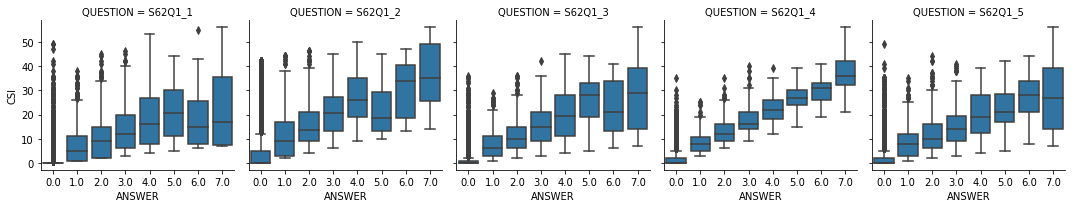

In [11]:
print(dfs.keys())
annee = 2014
summary(dfs[annee])
plot_question_csi(dfs[annee])

NB ROWS : 5157
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'S62Q1_1', 'S62Q1_2', 'S62Q1_3', 'S62Q1_4', 'S62Q1_5', 'CSI']
Number of households : 712

Number of data by town :
	TOWN 1.0 : 825(number of rows)
	TOWN 2.0 : 732(number of rows)
	TOWN 3.0 : 769(number of rows)
	TOWN 4.0 : 653(number of rows)
	TOWN 5.0 : 571(number of rows)
	TOWN 6.0 : 520(number of rows)
	TOWN 7.0 : 410(number of rows)
	TOWN 8.0 : 205(number of rows)
	TOWN 9.0 : 206(number of rows)
	TOWN 10.0 : 130(number of rows)
	TOWN 11.0 : 40(number of rows)
	TOWN 12.0 : 48(number of rows)
	TOWN 13.0 : 36(number of rows)
	TOWN 15.0 : 12(number of rows)

|       |     S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|------------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5144        | 5074        | 5073        | 5067        | 5064        | 5157       |
| mean  |    0.880832 |    0.215412 |    0.777252 |    0.561279 |    0.718602 |    4.4

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


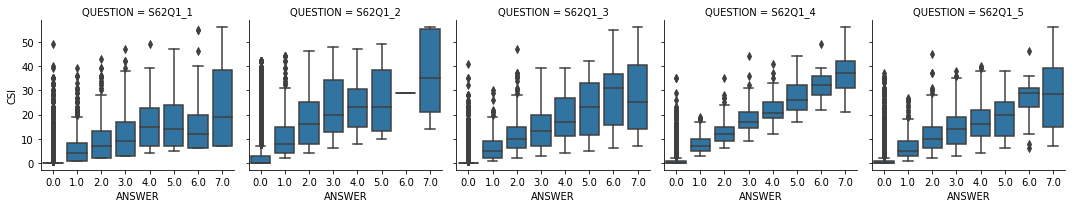

In [12]:
annee = 2015
summary(dfs[annee])
plot_question_csi(dfs[annee])

NB ROWS : 5233
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'S62Q1_1', 'S62Q1_2', 'S62Q1_3', 'S62Q1_4', 'S62Q1_5', 'CSI']
Number of households : 714

Number of data by town :
	TOWN 1.0 : 828(number of rows)
	TOWN 2.0 : 740(number of rows)
	TOWN 3.0 : 777(number of rows)
	TOWN 4.0 : 666(number of rows)
	TOWN 5.0 : 579(number of rows)
	TOWN 6.0 : 519(number of rows)
	TOWN 7.0 : 427(number of rows)
	TOWN 8.0 : 221(number of rows)
	TOWN 9.0 : 207(number of rows)
	TOWN 10.0 : 132(number of rows)
	TOWN 11.0 : 40(number of rows)
	TOWN 12.0 : 48(number of rows)
	TOWN 13.0 : 37(number of rows)
	TOWN 15.0 : 12(number of rows)

|       |     S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |    S62Q1_5 |        CSI |
|:------|------------:|------------:|------------:|------------:|-----------:|-----------:|
| count | 5181        | 5146        | 5145        | 5144        | 5141       | 5233       |
| mean  |    0.736537 |    0.187913 |    0.643149 |    0.446734 |    0.56098 |    3.59966

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


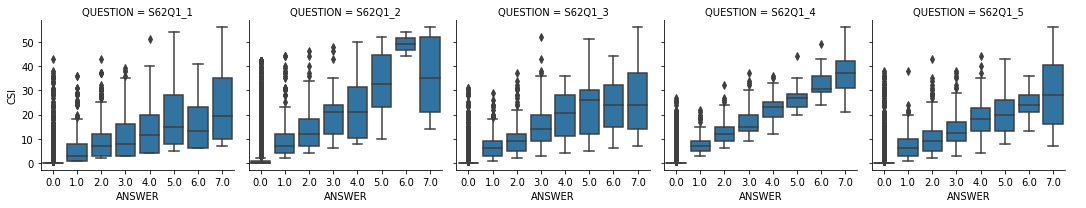

In [13]:
annee = 2016
summary(dfs[annee])
plot_question_csi(dfs[annee])

NB ROWS : 5232
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'S62Q1_1', 'S62Q1_2', 'S62Q1_3', 'S62Q1_4', 'S62Q1_5', 'CSI']
Number of households : 711

Number of data by town :
	TOWN 1.0 : 827(number of rows)
	TOWN 2.0 : 740(number of rows)
	TOWN 3.0 : 773(number of rows)
	TOWN 4.0 : 666(number of rows)
	TOWN 5.0 : 570(number of rows)
	TOWN 6.0 : 529(number of rows)
	TOWN 7.0 : 428(number of rows)
	TOWN 8.0 : 220(number of rows)
	TOWN 9.0 : 208(number of rows)
	TOWN 10.0 : 131(number of rows)
	TOWN 11.0 : 42(number of rows)
	TOWN 12.0 : 48(number of rows)
	TOWN 13.0 : 36(number of rows)
	TOWN 15.0 : 12(number of rows)
	TOWN 24.0 : 1(number of rows)
	TOWN 35.0 : 1(number of rows)

|       |     S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|------------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5185        | 5182        | 5184        | 5183        | 5181        | 5232       |
| mean  |    0.980135 | 

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


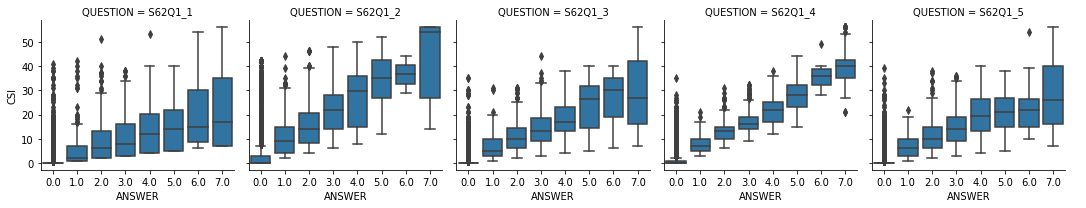

In [14]:
annee = 2017
summary(dfs[annee])
plot_question_csi(dfs[annee])

NB ROWS : 5165
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'S62Q1_1', 'S62Q1_2', 'S62Q1_3', 'S62Q1_4', 'S62Q1_5', 'CSI']
Number of households : 710

Number of data by town :
	TOWN 1.0 : 807(number of rows)
	TOWN 2.0 : 725(number of rows)
	TOWN 3.0 : 776(number of rows)
	TOWN 4.0 : 653(number of rows)
	TOWN 5.0 : 569(number of rows)
	TOWN 6.0 : 524(number of rows)
	TOWN 7.0 : 426(number of rows)
	TOWN 8.0 : 216(number of rows)
	TOWN 9.0 : 200(number of rows)
	TOWN 10.0 : 132(number of rows)
	TOWN 11.0 : 41(number of rows)
	TOWN 12.0 : 48(number of rows)
	TOWN 13.0 : 36(number of rows)
	TOWN 15.0 : 12(number of rows)

|       |    S62Q1_1 |     S62Q1_2 |     S62Q1_3 |    S62Q1_4 |    S62Q1_5 |        CSI |
|:------|-----------:|------------:|------------:|-----------:|-----------:|-----------:|
| count | 5157       | 5149        | 5147        | 5146       | 5145       | 5165       |
| mean  |    1.05701 |    0.180618 |    0.870021 |    0.59658 |    0.76171 |    4.82439 |
| std

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


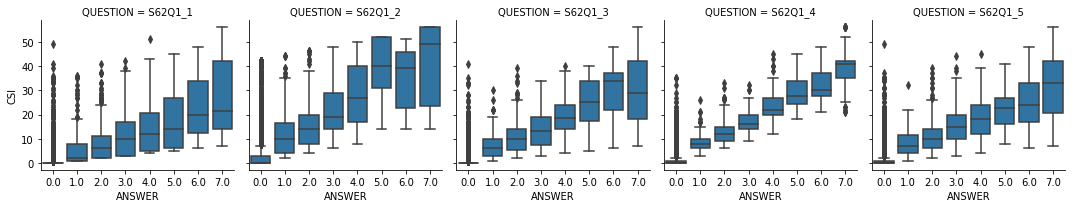

In [15]:
annee = 2018
summary(dfs[annee])
plot_question_csi(dfs[annee])

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


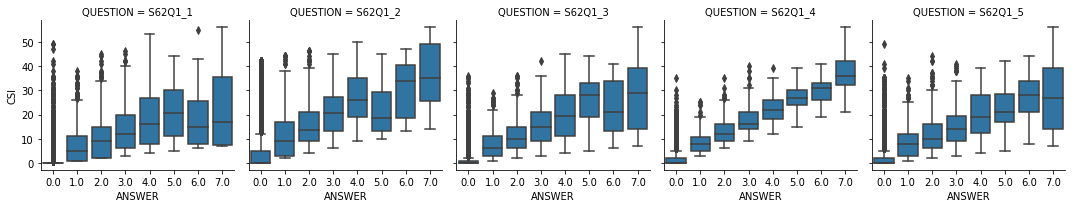

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


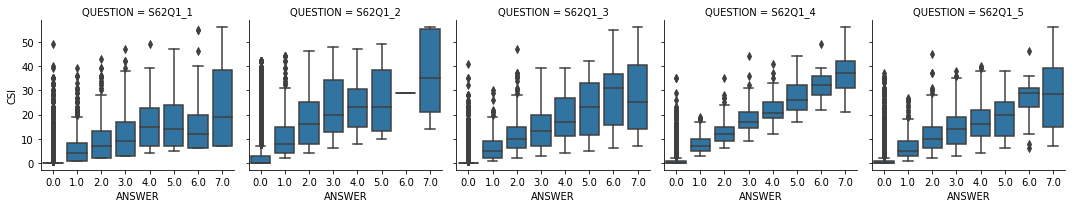

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


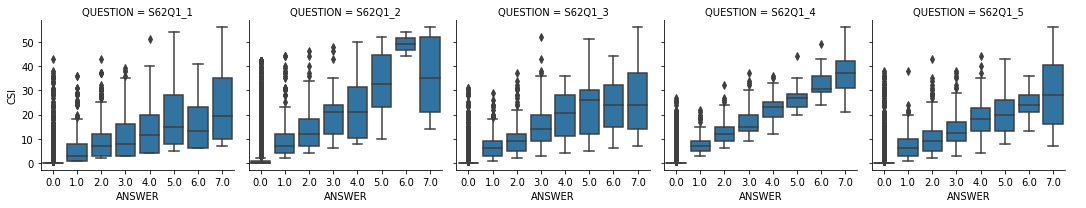

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


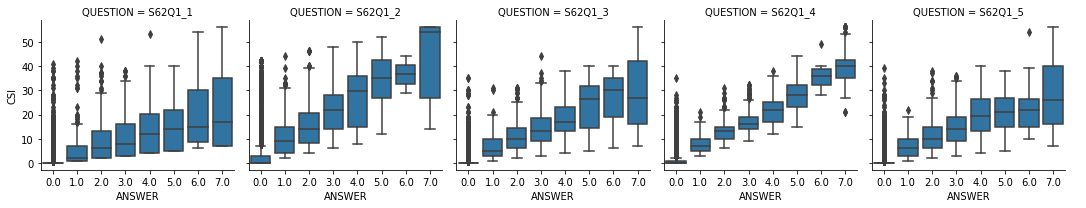

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


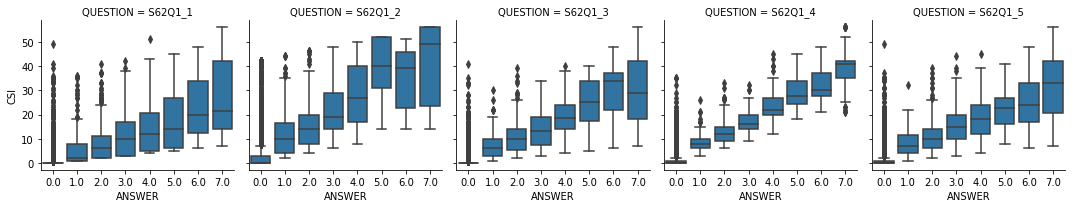

In [10]:
for k in dfs:
    # print(k)
    df = dfs[k]
    # plot_df = df.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="VALUE")

    # g = sns.FacetGrid(plot_df, col="QUESTION")
    # g.map(sns.boxplot, "VALUE", "CSI")
    # g.add_legend()
    # plt.show()
    plot_question_csi(df)


# COMPARISON OF EVERY YEAR

In [ ]:
# allez hop hop hop on plot

# CONCAT EVERY DATA FILE
Some functions we'll use to concat those files, we then add a column refering to the year of the file.

In [ ]:
raw_data = concat(dfs)

# SAVES ALL DATA CONCATENED IN A CSV FILE
raw_data.to_csv(path + 'donnees.csv')
raw_data

,REG,PROV,COM,VIL,MEN,CENQ,NB_REPA,TYP_JR,CONS_CER1,CONS_CER2,...,Type_men,Classe_SDA,S62Q2,S62Q3_1,S62Q3_2,S62Q3_3,S62Q2_c,S62Q4_3_cor1,S62Q2_1,PrimaryLast3
0,1.0,13.0,1.0,1.0,45.0,76.0,3.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,13.0,1.0,1.0,58.0,76.0,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,13.0,1.0,1.0,67.0,76.0,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,13.0,1.0,1.0,75.0,76.0,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,13.0,1.0,1.0,84.0,76.0,2.0,0.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25980,13.0,41.0,5.0,14.0,NaN,NaN,2.0,0.0,1.0,0.0,...,0.0,1.0,3.0,2.0,4.0,5.0,3.0,10000.0,3.0,1.0
25981,13.0,41.0,5.0,14.0,NaN,NaN,2.0,0.0,1.0,0.0,...,0.0,2.0,3.0,2.0,4.0,5.0,3.0,15000.0,3.0,1.0
25982,13.0,41.0,5.0,14.0,NaN,NaN,3.0,0.0,1.0,0.0,...,0.0,2.0,3.0,3.0,4.0,2.0,3.0,60000.0,3.0,1.0
25983,13.0,41.0,5.0,14.0,NaN,NaN,1.0,0.0,1.0,0.0,...,0.0,2.0,3.0,2.0,4.0,5.0,3.0,10000.0,3.0,1.0


# ANALYSE

Certaines colonnes ont des noms différents et représentant la même métrique, d'autres ne nous intéresse tout simplement pas.
On veut alors essayer de réduire le nombre de colonnes.

__D'abord quelques infos à propos du jeu de données__

In [ ]:
print("Total rows : {}\n".format(raw_data.shape[0]))

print("Number of rows containing a NaN value in each columns\n{}".format(raw_data.isna().sum()))

print("\nNumbers of rows by year")
for (year) in (raw_data.YEAR.unique()):
    print("\t {} : {}".format(year, raw_data[raw_data.YEAR == year].shape[0]))

Total rows : 25985

Number of rows containing a NaN value in each columns
REG                 0
PROV                0
COM                 0
VIL                 0
MEN              5198
                ...  
S62Q3_3         24141
S62Q2_c         20798
S62Q4_3_cor1    23285
S62Q2_1         20798
PrimaryLast3    20787
Length: 431, dtype: int64

Numbers of rows by year
	 20182019 : 5165
	 20172018 : 5232
	 20162017 : 5233
	 20152016 : 5157
	 20142015 : 5198


Let's see if there is the same amount of data over the years :

In [ ]:
for year in raw_data.YEAR.unique():
    print("YEAR {}/{} :".format(year[:4], year[4:]))
    print("\tNumber of missing CSI rows : {}/{}".format(raw_data[raw_data.YEAR == year].CSI.isna().sum(),
                                                        raw_data[raw_data.YEAR == year].shape[0]))
    print("\tNumber of REG : {}".format(raw_data[raw_data.YEAR == year].loc[:, "REG"].unique().shape[0]))
    print("\tNumber of PROV : {}".format(raw_data[raw_data.YEAR == year].loc[:, "PROV"].unique().shape[0]))
    print("\tNumber of COM : {}".format(raw_data[raw_data.YEAR == year].loc[:, "COM"].unique().shape[0]))
    print("\tNumber of VIL : {}".format(raw_data[raw_data.YEAR == year].loc[:, "VIL"].unique().shape[0]))
    

YEAR 2018/2019 :
	Number of missing CSI rows : 5165/5165
	Number of REG : 13
	Number of PROV : 45
	Number of COM : 14
	Number of VIL : 66
YEAR 2017/2018 :
	Number of missing CSI rows : 55/5232
	Number of REG : 13
	Number of PROV : 45
	Number of COM : 16
	Number of VIL : 66
YEAR 2016/2017 :
	Number of missing CSI rows : 102/5233
	Number of REG : 13
	Number of PROV : 45
	Number of COM : 14
	Number of VIL : 69
YEAR 2015/2016 :
	Number of missing CSI rows : 5157/5157
	Number of REG : 13
	Number of PROV : 45
	Number of COM : 14
	Number of VIL : 66
YEAR 2014/2015 :
	Number of missing CSI rows : 58/5198
	Number of REG : 13
	Number of PROV : 45
	Number of COM : 14
	Number of VIL : 67


__Now let's focus on columns that we're interested in :__

In [ ]:
for col in raw_data.columns:
    print(col)

REG
PROV
COM
VIL
MEN
CENQ
NB_REPA
TYP_JR
CONS_CER1
CONS_CER2
CONS_CER3
CONS_CER4
CONS_CER5
CONS_CER6
CONS_CER7
NBR_CONS_CER
PROV_CER
CONS_RACTUB1
CONS_RACTUB2
CONS_RACTUB3
CONS_RACTUB4
CONS_RACTUB5
CONS_RACTUB6
CONS_RACTUB7
NBR_CONS_RAC
PROV_RACTUB
CONS_LEGUMIN1
CONS_LEGUMIN2
CONS_LEGUMIN3
CONS_LEGUMIN4
CONS_LEGUMIN5
CONS_LEGUMIN6
CONS_LEGUMIN7
NBR_CONS_LEG
PROV_LEGUMIN
CONS_OLEA1
CONS_OLEA2
CONS_OLEA3
CONS_OLEA4
CONS_OLEA5
CONS_OLEA6
CONS_OLEA7
NBR_CONS_OLEA
PROV_OLEA
CONS_LEGUM1
CONS_LEGUM2
CONS_LEGUM3
CONS_LEGUM4
CONS_LEGUM5
CONS_LEGUM6
CONS_LEGUM7
NBR_CONS_LEG_VITA
PROV_LEGUM
CONS_FEUILLE1
CONS_FEUILLE2
CONS_FEUILLE3
CONS_FEUILLE4
CONS_FEUILLE5
CONS_FEUILLE6
CONS_FEUILLE7
NBR_CONS_FEUIL
PROV_FEUILLE
CONS_FRUIT1
CONS_FRUIT2
CONS_FRUIT3
CONS_FRUIT4
CONS_FRUIT5
CONS_FRUIT6
CONS_FRUIT7
NBR_CONS_FR_VITA
PROV_FRUIT
CONS_AUTLEGUM1
CONS_AUTLEGUM2
CONS_AUTLEGUM3
CONS_AUTLEGUM4
CONS_AUTLEGUM5
CONS_AUTLEGUM6
CONS_AUTLEGUM7
NBR_CONS_AUTLEG
PROV_AUTLEGUM
CONS_AUTRFRU1
CONS_AUTRFRU2
CONS_AUTRFRU

In [ ]:
# All those columns, are answers to different questions ask to compute a CSI score.
# don't know the difference between S62 and S63,
# some rows answer only to S62 questions, some answers to all S62 and S63 questions

S62_Q1 = ["S62Q1_1","S62Q1_2","S62Q1_3","S62Q1_4","S62Q1_5"]
S62_Q2 = ["S62Q21_1","S62Q21_2","S62Q22_1","S62Q22_2","S62Q23_1","S62Q23_2","S62Q24_1","S62Q24_2","S62Q25_1","S62Q25_2","S62Q26_1","S62Q26_2","S62Q27_1","S62Q27_2","S62Q28_1","S62Q28_2","S62Q29_1","S62Q29_2","S62Q210_1","S62Q210_2"]
S62_Q3 = ["S62Q3"]
S62_Q4 = ["S62Q4_1","S62Q5_1","S62Q4_2","S62Q5_2","S62Q4_3"]
S62_Q5 = ["S62Q5_3","S62Q2","S62Q3_1","S62Q3_2","S62Q3_3"]
S62_COR_DEF = ["S62Q2_c","S62Q4_3_cor1","S62Q2_1","S62Q3_cor","S62Q4_1_cor","S62Q4_1_def","S62Q4_2_cor","S62Q4_2_def","S62Q4_3_cor","S62Q4_3_def","S62Q5_1_cor","S62Q5_1_def","S62Q5_2_cor","S62Q5_2_def","S62Q5_3_cor","S62Q5_3_def", "S62Q24_1_COR","S62Q4_1_COR"]
S62 = S62_Q1 + S62_Q2 + S62_Q3 + S62_Q4 + S62_Q5 #+ S62_COR_DEF

S63_Q1 = ["S63Q1_A","S63Q1_B","S63Q1_C","S63Q1_D","S63Q1_E","S63Q1_F","S63Q1_G","S63Q1_H","S63Q1_I","S63Q1_J","S63Q1_K","S63Q1_L","S63Q1_M"]
S63_Q2 = ["S63Q2_A","S63Q2_B","S63Q2_C","S63Q2_D"]
S63_Q3 = ["S63Q3_A","S63Q3_B","S63Q3_C","S63Q3_D","S63Q3_E","S63Q3_F","S63Q3_G","S63Q3_H","S63Q3_I","S63Q3_J","S63Q3_K"]
S63 = S63_Q1 + S63_Q2 + S63_Q3

STRATEGIE = ["Stratégie1","Stratégie2","Stratégie3","Stratégie4","Stratégie5"]

# "CSI","YEAR" : those are also useful,
# the CSI column will surely be our target column, while S63 and S62 arrays will be our variables
# "REG", "PROV", "COM", "VIL" could also be considered, but not so sure about that yet

COL_TO_KEEP = ["REG", "COM", "PROV", "VIL", "MEN", "YEAR"]
COL_TO_KEEP += S62_Q1


__Some info about the S62 and S63 columns and some other columns__

We'll add some plots when we'll know what does the columns represent

In [ ]:
# Number of NaN values in each column of S62 type
raw_data.loc[:, S62].isna().sum()

S62Q1_1           145
S62Q1_2           269
S62Q1_3           272
S62Q1_4           282
S62Q1_5           292
S62Q21_1         5336
S62Q21_2         5724
S62Q22_1         5351
S62Q22_2         6913
S62Q23_1         5355
S62Q23_2         5884
S62Q24_1         5356
S62Q24_2         8960
S62Q25_1         5372
S62Q25_2         7200
S62Q26_1         5365
S62Q26_2         5595
S62Q27_1         5352
S62Q27_2         5645
S62Q28_1         5354
S62Q28_2         7778
S62Q29_1         5363
S62Q29_2         5755
S62Q210_1        5367
S62Q210_2        7833
S62Q3            5386
S62Q4_1           430
S62Q5_1          5411
S62Q4_2          6897
S62Q5_2         10241
S62Q4_3         17399
S62Q5_3         18419
S62Q2           20876
S62Q3_1         20961
S62Q3_2         22354
S62Q3_3         24141
S62Q2_c         20798
S62Q4_3_cor1    23285
S62Q2_1         20798
S62Q3_cor       15615
S62Q4_1_cor     15760
S62Q4_1_def     15698
S62Q4_2_cor     14321
S62Q4_2_def     18369
S62Q4_3_cor     23006
S62Q4_3_de

In [ ]:
# Number of NaN values in each column of S63 type
raw_data.loc[:, S63].isna().sum()

S63Q1_A    162
S63Q1_B    140
S63Q1_C    189
S63Q1_D    160
S63Q1_E    187
S63Q1_F    176
S63Q1_G    136
S63Q1_H    130
S63Q1_I    145
S63Q1_J    181
S63Q1_K    130
S63Q1_L    128
S63Q1_M    500
S63Q2_A    233
S63Q2_B    177
S63Q2_C    168
S63Q2_D    171
S63Q3_A    124
S63Q3_B    188
S63Q3_C    150
S63Q3_D    170
S63Q3_E    221
S63Q3_F    201
S63Q3_G    165
S63Q3_H    204
S63Q3_I    228
S63Q3_J    232
S63Q3_K    309
dtype: int64

In [ ]:
# Number of NaN values in CSI column
raw_data.loc[:, "CSI"].isna().sum()

10537

You can notice that half the data is not mesured, some rows could be filled by calculating the CSI with the help of all S62 and S63 columns. 

# FEATURE ENGINEERING
----
We'll see if there is any transformation needed in the data, we could also complete some rows by computing the CSI score.

# MODELING